In [1]:
# 3 cavity modes, 3lvl, multiAtom, Interactions

%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.signal import chirp, find_peaks, peak_widths
from qutip import *
import time
import itertools 
import pickle

# parameter integrators 
import EFTParams
import Integrands
import Wavefunctions
import importlib
importlib.reload(EFTParams)
importlib.reload(Integrands)
importlib.reload(Wavefunctions)

In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylelib/_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/dawit/.local/lib/python3.6/site-packages/matplotlib/mpl-data/stylel

<module 'Wavefunctions' from '/home/dawit/Desktop/TopPhotonics/Wavefunctions.py'>

In [2]:
# for saving and loading param dictionaries
def save_obj(obj, name):
    with open('obj/'+ name + '.pkl', 'wb') as f:
        pickle.dump(obj, f, pickle.HIGHEST_PROTOCOL)

def load_obj(name):
    print('atempting to load: ', name)
    with open('obj/' + name + '.pkl', 'rb') as f:
        return pickle.load(f)
    
def computeU(epsabs, epsrel, wf, H, C6, w, modes, name):
    print('Computing U with H: ', str(H))
    U = { }
    indxs = itertools.product(modes, repeat = 4)
    for indx in indxs:
        # get interaction value from Logan code
        
        if (indx[0] >= indx[1]) and (indx[2] >= indx[3]):
        
            feed = [(i,) for i in indx]
            U[indx] = EFTParams.U_parameter(wf, feed, C6, w, H, epsabs=epsabs, epsrel=epsrel)

    save_obj(U, name)
    print('finished computing and saving as: ', name)
    
    return U
    
def indicesToRemove(ntensor, ncav, max_exc=2):
    
    # (2, 0, ...) ==> 2(3^8) th index 
    # (1, 1, 0, ....) ==> 3^8 + 3^7 th index 
    
    zeros = ntensor*[0]
    states = [zeros]
    for i in range(ntensor): 
        twos = ntensor*[0]
        twos[i] = 2 # hard coded for now
        
        ones = ntensor*[0]
        ones[i] = 1
        
        states.append(twos)
        states.append(ones)

        for j in range(i): 
            one2s = ntensor*[0]    
            one2s[i] = 1
            one2s[j] = 1
            states.append(one2s)
    
    keep = []    
    # compute index for given state
    for state in states:
        # state = [1, 1, 0, 0, 0,..., 0] and so on
        indx = 0
        for i in range(ntensor):
            val = state[i]
            indx += val*(ncav**(ntensor - 1 - i))
            
        keep.append(indx)
    
    total = list(range(ncav ** ntensor))
    remove = [i for i in total if i not in keep]
    
    return remove

def projectOP(op, indices_remove):
    
    projected_op = op.eliminate_states(indices_remove, normalize=False)
    
    return projected_op

In [3]:
# Modeling multiple cavity modes with interaction term

# When it is time to do computations,
# we want no more than 2 excitations at any of the channels at any given time

### 
# c0, p0, r0 ; c1, p1, r1 ; c2, p2, r2 (9 modes)
# we allow at most 2 excitations ==>
# 1 + 2*9 + 9^2/2 = 55 states 
###

cav_modes = 3 # num of cav modes
cav_max = 3 # this means can have 0, 1 or 2 photons per mode 
max_excitations = 2 # maximum total excitations allowed in system
phot_init = 0

remove = indicesToRemove(9, 3)

# generic initial state
cav0 = basis(cav_max, n = phot_init)
p0 = basis(cav_max, n = phot_init)
r0 = basis(cav_max, n = phot_init)
#
cav = tensor([cav0 for i in range(cav_modes)])
exc = tensor([p0 for i in range(cav_modes)]) 
ryd = tensor([r0 for i in range(cav_modes)])
#
psi0 = projectOP(tensor([cav, exc, ryd]), remove)

print('size of initial state: ', psi0.shape[0])

# collective bosonic a, p, r state destruction_ops
# list representation of operators to be tensored later
print('Initializing operators ...')
Id_cav = [qeye(cav_max) for i in range(cav_modes)]
Id_p = Id_cav
Id_r = Id_cav


a = ['' for i in range(cav_modes)] # to be populated by a0, a1, a2
p = ['' for i in range(cav_modes)] # to be populated by p0, p1, p2
r = ['' for i in range(cav_modes)] # to be populated by r0, r1, r2

# populate a
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    temp = temp + Id_p + Id_r
    #a[i] = tensor(temp)    
    a[i] = projectOP(tensor(temp), remove)
    
print('size of a[0]: ', a[0].shape)
    
# populate p
temp = []
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    temp = Id_cav + temp + Id_r
    #p[i] = tensor(temp)
    p[i] = projectOP(tensor(temp), remove)
    
print('size of p[0]: ', p[0].shape)

# populate r  
temp = []
for i in range(cav_modes):
    temp = [qeye(cav_max) for j in range(cav_modes)]
    temp[i] = destroy(cav_max)
    temp = Id_cav + Id_p + temp
    #r[i] = tensor(temp)
    r[i] = projectOP(tensor(temp), remove)
    
print('size of r[0]: ', r[0].shape)
    
temp = []
    
# cav-p exchange, p-r exchange, drive
pexchange = [(p[i].dag()*a[i] + a[i].dag()*p[i]) for i in range(cav_modes)]
print('size of pexchange[0]: ', pexchange[0].shape)
rexchange = [(r[i].dag()*p[i] + p[i].dag()*r[i]) for i in range(cav_modes)] 
print('size of rexchange[0]: ', rexchange[0].shape)


print('opertors initialized.')

size of initial state:  55
Initializing operators ...
size of a[0]:  (55, 55)
size of p[0]:  (55, 55)
size of r[0]:  (55, 55)
size of pexchange[0]:  (55, 55)
size of rexchange[0]:  (55, 55)
opertors initialized.


In [4]:
# parameters placeholders
c = [1, 1, 1]
delta_c = [1, 1, 1]
delta_e = 1
delta_2 = 1
G = [1, 1, 1] 
omega = 1
prb = 0.3 

# decay params
kappa = 1.4
gamma = 6
gamma_r = 0.1

# collapse operators
# NOTE: each mode gets its own collapse operator 
# but the decay param is identical for all modes
c_phot = [np.sqrt(kappa)*a_k for a_k in a]
c_p = [np.sqrt(gamma)*p_k for p_k in p]
c_r =  [np.sqrt(gamma_r)*r_k for r_k in r]

collapse = c_phot + c_p + c_r

In [5]:
def g2(rho, H, dest, times, c=collapse, options=Options(tidy=False)):
    rho_m1 = dest * rho * dest.dag()
    norm = np.trace(rho_m1)
    rho_m1 = dest * (rho/norm) * dest.dag()
    rho_m1_t = mesolve(H, rho_m1, times, c, [dest.dag()*dest], options=options)
    
    num = rho_m1_t.expect[0] * norm
    den = np.power(np.trace(dest.dag()*dest*rho), 2)
    
    return num/den

def g2_mixed(rho, H, dest1, dest2, times, c=collapse, options=Options(tidy=False)):
    rho_m1 = dest1 * rho * dest1.dag()
    norm = np.trace(rho_m1)
    rho_m1 = dest1 * (rho/norm) * dest1.dag()
    rho_m1_t = mesolve(H, rho_m1, times, c, [dest2.dag()*dest2], options=options)
    
    num = rho_m1_t.expect[0] * norm
    den = np.trace(dest1.dag()*dest1*rho) * np.trace(dest2.dag()*dest2*rho) # should there be a t evolution here?  
    
    return num/den

# calculate H_eff given params
def H_eff(c, delta_c, delta_e, delta_2, G, omega, prb):
    # Effective Hamiltonian

    tot_drive = sum([c_k*a_k for c_k, a_k in zip(c, a)])
    tot_drive = prb*(tot_drive + tot_drive.dag())
    
    tot_phot = sum([coeff*op.dag()*op for coeff, op in zip(delta_c,a)])
    tot_p = delta_e * sum([op.dag()*op for op in p])
    tot_r = delta_2 * sum([op.dag()*op for op in r])
    
    tot_pexchange = sum([coeff*op for coeff, op in zip(G,pexchange)])
    tot_rexchange = omega * sum(rexchange)

    H_eff = tot_drive + tot_phot + tot_p + tot_r + tot_pexchange + tot_rexchange
    
    return H_eff


def H_eff_2(c, delta_c, delta_e, delta_2, G, omega, prb):
    # Effective Hamiltonian
    
    # project first 
    remove = indicesToRemove(9, 3)
    ap = [projectOP(i, remove) for i in a]
    pp = [projectOP(i, remove) for i in p]
    rp = [projectOP(i, remove) for i in r]
    pexchangep = [projectOP(i, remove) for i in pexchange]
    rexchangep = [projectOP(i, remove) for i in rexchange]
    #
    
    tot_drive = sum([c_k*a_k for c_k, a_k in zip(c, ap)])
    tot_drive = prb*(tot_drive + tot_drive.dag())
    
    tot_phot = sum([coeff*op.dag()*op for coeff, op in zip(delta_c,ap)])
    tot_p = delta_e * sum([op.dag()*op for op in pp])
    tot_r = delta_2 * sum([op.dag()*op for op in rp])
    
    tot_pexchange = sum([coeff*op for coeff, op in zip(G,pexchangep)])
    tot_rexchange = omega * sum(rexchangep)

    H_eff = tot_drive + tot_phot + tot_p + tot_r + tot_pexchange + tot_rexchange
    
    return H_eff

#def H_ryd_int(cav_modes, U):
#    # build indices
#    temp = []
#    for a in range(cav_modes):
#        for b in range(a+1):
#            temp.append((a,b))
            
#    indxs = []
#    for x in temp:
#        for y in temp:
#            indxs.append(tuple(list(x + y)))
            
#    #print(indxs)
            
#    H_ryd_int = sum([U[indx]*r[indx[0]].dag()*r[indx[1]].dag()*r[indx[2]]*r[indx[3]] for indx in indxs])
    
#    return H_ryd_int

# del_omega == np.ones((Ncav, Ncav, Ncav, Ncav))
#def H_exch_int(cav_modes, del_omega):
#    # build indices 
#    first = []
#    for a in range(cav_modes):
#        for b in range(a+1):
#            first.append((a,b))
#            
#    second = []
#    for c in range(cav_modes):
#        for d in range(cav_modes):
#            second.append((c,d))
#    
#    indxs = []
#    for x in first:
#        for y in second:
#            indxs.append(tuple(list(x + y)))
            
#    #print(indxs)
    
#    H_exch_int = sum([del_omega[indx]*r[indx[0]].dag()*r[indx[1]].dag()*r[indx[2]]*p[indx[3]] for indx in indxs])
#    H_exch_int += H_exch_int.dag()
#    
#    return H_exch_int 

# DICT IMPLEMENTATIONS
def H_ryd_int(U):
    
    # remove repeated indices from U
    
    H = 0
    for indx in U.keys():
        
        if not (indx[0] >= indx[1]) and (indx[2] >= indx[3]):
            print('indexing problem!')
            pass 
        
        H += U[indx]*r[indx[0]].dag()*r[indx[1]].dag()*r[indx[2]]*r[indx[3]]
                                                                            
    return H

def H_exch_int(full_del_omega):
    
    # remove repeated indices from del_omega
    
    old_keys = full_del_omega.keys()
    new_keys = set( tuple(sorted(k)) for k in old_keys)
    
    del_omega = {k : full_del_omega[k] for k in new_keys}
    
    H = 0
    for indx in del_omega.keys():
        H  += del_omega[indx]*r[indx[0]].dag()*r[indx[1]].dag()*r[indx[2]]*p[indx[3]]
    
    H += H.dag()
                                                                            
    return H

g2(0):  (0.040914789576657694+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'DARK|mode=1 0 0|U=5| g=5 | $\\Omega$ =2 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

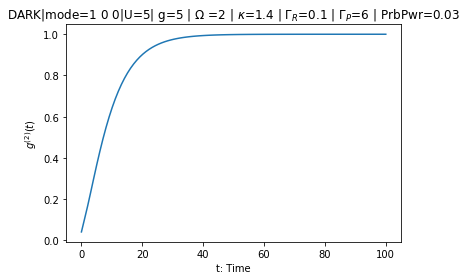

In [6]:
# Test [1] g2 supression at central peak

# Testing for U_0000 (a[0]) mode

# params
max_excitations = 2
c = [1, 0, 0]
delta = 0 # @ dark mode peak
delta_c = [delta, 0, 0] 
delta_e = delta
delta_2 = delta
G = [5, 0, 0] 
omega = 2
U = {(0,0,0,0) : 5}
#del_omega = {(0,0,0,0): 5, ...} 
prb = 0.03

# Hamiltonian
H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) + H_ryd_int(U)

rho_ss = steadystate(H, collapse, method='direct')
times = np.linspace(0, 100, 100)

g2_t = g2(rho_ss, H, a[0], times)

print('g2(0): ', g2_t[0]) # we expect 0.04 ish

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('DARK' + '|mode='+ " ".join(str(x) for x in c) + '|U='+str(U[(0,0,0,0)]) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

atempting to load:  U_contact
(0.9442210085593896+0j)


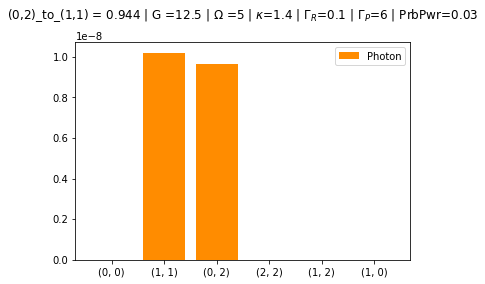

In [51]:
# Test [2] make (1,1) -> (0, 2) Laughlin State
#
# Observe signature of Laughlin State 
# I wonder if there is a way of visualizing an L-state
# Maybe a wigner plot or something 

# params
max_excitations = 2 # not implemented as of now
c = [0, 1, 0] # excite the |0> mode 
delta = 0 
delta_c = [delta, delta, delta] 
delta_e = delta
delta_2 = delta
G = [12.5, 12.5, 12.5] # same p-coupling const
omega = 5

# want (1, 1) -> (0, 2)

# wholesale copied from Logan's code
epsabs=1e-8
epsrel=0.1
wf = Wavefunctions.wf_lll_radial_jit
# to get more (1,1) -> (0,2) we let ryd interactions be longer ranged
H = 10**2 # contact limit for rydberg interaction (int dist is inverse of H value)
C6 = 1
w = 1
try:
    U = load_obj('U_contact')
except:
    U = computeU(epsabs, epsrel, wf, H, C6, w, (0,1,2), 'U_contact')

# NOTE: (0,0,0,0) is not the same thing in my code as in Logan's
# map ang momentum values in U.keys to indices for my code 
# e.g mapp = {3 : 0 , 6 : 1, 9 : 2}

# ang mom (0, 1, 2) -> index (0, 1, 2)
mapp = {0 : 0, 1 : 1, 2 : 2}
mapp_invert = {v : k for k, v in mapp.items()}
U = {tuple([mapp[i] for i in name]) : val for name, val in U.items()}

#print(U)

# set to 0 for now which is the ideal version 
# del_omega = {(0,0,0,0): 5}
prb = 0.03

# Hamiltonian
H = H_eff(c, delta_c, delta_e, delta_2, G, omega, prb) + H_ryd_int(U) #+ H_exch_int(del_omega)
rho_ss = steadystate(H, collapse, method='direct')

# set H2020 = H1111 = H1120 = H2011 = 66 for the ideal case
s20 = (r[2].dag()*r[0].dag()*psi0).unit()
s11 = (r[1].dag()*r[1].dag()*psi0).unit()
ind20 = np.nonzero(s20)[0][0] # get the 20 state index 
ind11 = np.nonzero(s11)[0][0]
H2020 = H.matrix_element(s20, s20)
H_arr = H.full()
H_arr[ind11][ind11] = H2020
H_arr[ind11][ind20] = H2020
H_arr[ind20][ind11] = H2020
# Ideal Hamiltonian
H = Qobj(H_arr)

# Plots
# bar plot for <00> <11> <22> <02> and so on
# get all 2 excitation states
states = [(0,0), (1,1), (0,2), (2,2), (1,2), (1, 0)]
nums = {(ind[0], ind[1]) : np.trace((ket2dm(a[ind[0]].dag()*a[ind[1]].dag()*psi0).unit())*rho_ss) for ind in states}

out_over_in = nums[(0,2)] / nums[(1,1)]
print(out_over_in)

xs = list(nums.keys())
x = np.arange(len(xs))
labels = map((lambda tup: (mapp_invert[tup[0]], mapp_invert[tup[1]])), xs)
ys = np.real(list(nums.values()))
fig, ax = plt.subplots()
plt.bar(x, ys,label="Photon", color="darkorange")
# inverting back to ang momentum lables
plt.xticks(x, labels) 
plt.legend(loc="upper right")
plt.title('(0,2)_to_(1,1) = '+str(out_over_in)[1:6] + ' | G ='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb),y=1.08)
plt.show()

**NOTE: When G and $\Omega$ are low, we expect that Rydbergs will have correct ratio of |02> to |11> state
while photons should produce significantly less |0,2> (output) modes.**

*This is expected behavior which can be seen in the code above by lowering G and Omega to 1/3 of their values.*

(0.9671780902035066+0j)


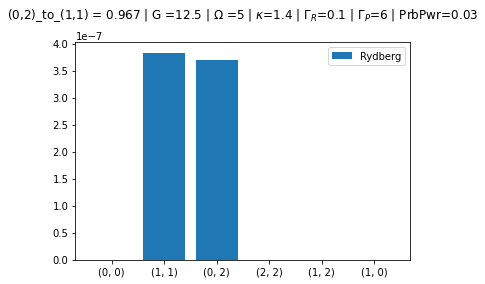

Ryd and Phot out of synch if co-operativity low. But that is expeted and is a positive demonstration of that fact.


In [52]:
# Test [2.1] plot number values for by counting rydbergs instead of photons and compare to photons 

# Plots
# bar plot for <00> <11> <22> <02> and so on
# get all 2 excitation states by counting rydbergs

states = [(0,0), (1,1), (0,2), (2,2), (1,2), (1, 0)]
nums = {(ind[0], ind[1]) : np.trace((ket2dm(r[ind[0]].dag()*r[ind[1]].dag()*psi0).unit())*rho_ss) for ind in states}

out_over_in = nums[(0,2)] / nums[(1,1)]
print(out_over_in)

xs = list(nums.keys())
x = np.arange(len(xs))
labels = map((lambda tup: (mapp_invert[tup[0]], mapp_invert[tup[1]])), xs)
ys = np.real(list(nums.values()))
fig, ax = plt.subplots()
plt.bar(x, ys, label='Rydberg')
plt.legend(loc="upper right")
plt.title('(0,2)_to_(1,1) = '+str(out_over_in)[1:6] + ' | G ='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb), y=1.08)
# inverting back to ang momentum lables
plt.xticks(x, labels) 
plt.show()

print('Ryd and Phot out of synch if co-operativity low. But that is expeted and is a positive demonstration of that fact.')

(0.026906143685361025+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'mode=0 1 0| g=12.5 | $\\Omega$ =5 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

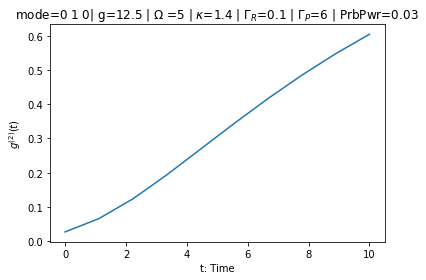

In [10]:
# Test [2.2] cont'd (1,1) -> (0,2)

# correlation of the injected mode (in our case g_11)

inj_mode = c.index(1) # injected mode: 1

times = np.linspace(0, 10, 10)
g2_t = g2(rho_ss, H, a[inj_mode], times)

print(g2_t[0]) # should be very close to 0

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('mode='+ " ".join(str(x) for x in c) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

The old g2 function does not work for mixed states. The correct formula for the mode (0,2) is: 

$$g^{(2)}(t) = \frac{ \langle \psi | a_0^\dagger(0)a_2^\dagger(t)a_2(t)a_0(0) | \psi \rangle }{N_0(0)N_2(0)}$$

(541367.7488485574+0j)


/home/dawit/.local/lib/python3.6/site-packages/numpy/core/_asarray.py:83: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'mode=0 1 0| g=12.5 | $\\Omega$ =5 | $\\kappa$=1.4 | $\\Gamma_R$=0.1 | $\\Gamma_P$=6 | PrbPwr=0.03')

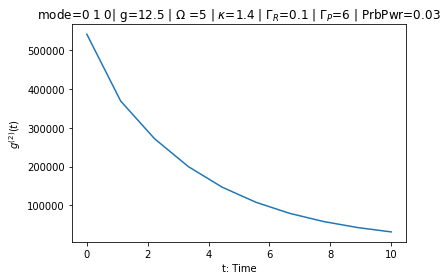

In [11]:
# Test [2.3] cont'd (1,1) -> (0,2)

# g2_02,  correlation of the expected output mode

out_modes = [a[0], a[2]]

# my g2 function does not work here 

times = np.linspace(0, 10, 10)
g2_t = g2_mixed(rho_ss, H, out_modes[0], out_modes[1], times) # makes more sense!
 
print(g2_t[0]) # should be large because 0 and 2 are created at the same time by the dominating reaction

# plot g2_t
fig=plt.figure()
plt.plot(times, g2_t)
plt.xlabel('t: Time')
plt.ylabel('$g^{(2)}(t)$')
plt.title('mode='+ " ".join(str(x) for x in c) + '| g='+str(G[0]) +  ' | $\Omega$ =' + str(omega) + ' | $\kappa$=' + str(kappa)  + ' | $\Gamma_R$=' + str(gamma_r) +' | $\Gamma_P$=' + str(gamma) + ' | PrbPwr=' + str(prb))

In [32]:
# Test [2.4] Laughlin State minimizes interaction energy to 0

# Laughlin state = |11> - alpha_01 |02> but alpha_01 = 1 
# (Source: Observation of L states, page 25)

mapp = {0:0, 1:1, 2:2} # old map 
mapp = {v : k for k, v in mapp.items()} # inversion

s20 = (r[2].dag()*r[0].dag()*psi0).unit()
s11 = (r[1].dag()*r[1].dag()*psi0).unit()

l_state = (s11 - s20).unit()
#l_state = ((r[mapp[1]].dag() * r[mapp[1]].dag()) - (r[mapp[2]].dag() * r[mapp[0]].dag())) * psi0
#l_state = l_state.unit() # normalize state
# Eventhough they should be equal qutip does something weird here

l_int_energy  = expect(H, l_state) # expect value = 0 ; 
# something else is bringing the 3.8 factor!
print('Laughlin E: ', l_int_energy)

# Anti Laughlin state 
al_state = (s11 + s20).unit()
#al_state = (r[mapp[1]].dag() * r[mapp[1]].dag() + r[mapp[2]].dag() * r[mapp[0]].dag()) * psi0
#al_state = al_state.unit()
al_int_energy = expect(H, al_state) # expect value =!= 0
print('Anti-Laughlin E: ', al_int_energy)

Laughlin E:  0.0
Anti-Laughlin E:  132.20585694241583


In [35]:
# Test [2.5] <20|H|20> = <11|H|11> = <11|H|20> to create a Laughlin b/c

# <L|H|L> = <20|H|20> + <11|H|11> - 2*<11|H|20> = 0

# because L state has 0 interaction energy 

s20 = (r[2].dag()*r[0].dag()*psi0).unit()
s11 = (r[1].dag()*r[1].dag()*psi0).unit()


H2020 = H.matrix_element(s20.dag(), s20)
H1111 = H.matrix_element(s11.dag(), s11)
H1120 = H.matrix_element(s20.dag(), s11)
H2011 = H.matrix_element(s11.dag(), s20)

#H.matrix_element(bra,ket)

print('NOTE: |nm> ryds not eigen-states because of exchange term. Polaritons are eigen-states.\n')
print('<20|H|20> =', H2020)
print('<11|H|11> =', H1111)
print('<11|H|20> =', H1120) 
print('<20|H|11> =', H2011)
print('<L|H|L> =', H2020 + H1111 - H1120 - H2011)

NOTE: |nm> ryds not eigen-states because of exchange term. Polaritons are eigen-states.

<20|H|20> = (66.10292847120793+0j)
<11|H|11> = (66.10292847120793+0j)
<11|H|20> = (66.10292847120793+0j)
<20|H|11> = (66.10292847120793+0j)
<L|H|L> = 0j


In [56]:
# Test [2.6] check steady-state in coherence superposition to give only a |L> state
# |rho_ss2011| ~= |rho_ss2020| and so on

# i.e we want to make sure that our state is not just a clasical mixed state of |11> and |02> but 
# a pure superposition of them. That is we want to see (2) below 

#(1) rho_c = 1/2 |11><11| + 1/2 |02><02|
#(2) rho_q = 1/2 (|11> - |02>)(<11| - <02|) = 1/2 |11><11| + 1/2 |02><02| -1/2|11><02| -1/2 |02><11|

# observe the steady state in {|11> , |02>} basis 

s20 = (r[2].dag()*r[0].dag()*psi0).unit()
s11 = (r[1].dag()*r[1].dag()*psi0).unit()

rho_1111 = np.abs(rho_ss.matrix_element(s11.dag(), s11))
rho_2020 = np.abs(rho_ss.matrix_element(s20.dag(), s20))
rho_2011 = np.abs(rho_ss.matrix_element(s20.dag(), s11))
rho_1120 = np.abs(rho_ss.matrix_element(s11.dag(), s20))

print('|<20|rho_ss|20>| =', rho_2020)
print('|<11|rho_ss|11>| =', rho_1111)
print('|<11|rho_ss|20>| =', rho_1120) 
print('|<20|rho_ss|11>| =', rho_2011)

|<20|rho_ss|20>| = 3.7143349104189276e-07
|<11|rho_ss|11>| = 3.8403836356935917e-07
|<11|rho_ss|20>| = 3.776833319347028e-07
|<20|rho_ss|11>| = 3.776833319347028e-07


**This confirms that we infact have a laughlin state and not a calssically mixed state.**

In [ ]:
'''
Next Steps

---
refactor code: Convert this to a Class named Test_Ryd

---
Leading Question: Is this approximation sensible? within 30% 

plot U vs H using Logan plot 
linear fit to get U values without resonances
repeat for del_omega

get c6 and w from page 15 of ET_redux 

get omega, G, del_p (shoudl be del_cs) page 29 and 30 from recent supplemental

del_C = 0
del_R = 0

---
Test: Fig 3. 
'''